In [1]:
import pandas as pd
import numpy as np
from io import StringIO
from classes import BalancedUndersamplingShuffle, balanced_sampling
from helpers import plot_learning_curve, plot_validation_curve, fit_and_score_pipeline, exp_range, \
    validation_curve_with_undersampling, plot_validation_curve_with_undersampling
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.metrics import check_scoring
from sklearn.model_selection._validation import _fit_and_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import fbeta_score, make_scorer

In [2]:
from scipy.io import arff

with open('1year.arff','r') as f:
    data1, meta1 = arff.loadarff(f)
    data1 = np.asarray(data1.tolist(), dtype=np.float32)
    print(data1.shape)

with open('2year.arff','r') as f:
    data2, meta2 = arff.loadarff(f)
    data2 = np.asarray(data2.tolist(), dtype=np.float32)
    print(data2.shape)

with open('3year.arff','r') as f:
    data3, meta3 = arff.loadarff(f)
    data3 = np.asarray(data3.tolist(), dtype=np.float32)
    print(data3.shape)

with open('4year.arff','r') as f:
    data4, meta4 = arff.loadarff(f)
    data4 = np.asarray(data4.tolist(), dtype=np.float32)
    print(data4.shape)

with open('5year.arff','r') as f:
    data5, meta5 = arff.loadarff(f)
    data5 = np.asarray(data5.tolist(), dtype=np.float32)
    print(data5.shape)


(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [3]:
data = np.concatenate([data1, data2, data3, data4, data5], axis=0)
data[np.isnan(data)] = 0


# data = data[~np.isnan(data).any(axis=1)]
print(data[:,-1])

print(f'data.shape={data.shape}')

X, y = data[:,:-1], data[:, -1]
# X, y, idx = balanced_sampling(X, y, r = 3, random_state=42)

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y.astype(str))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print(f'X.shape={X.shape}, y.shape={y.shape}')

[0. 0. 0. ... 1. 1. 1.]
data.shape=(43405, 65)
X.shape=(43405, 64), y.shape=(43405,)


# Try naive fit

In [15]:
# Naive fit doesn't converge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
classifier = MLPClassifier(solver='sgd', alpha=1e-2, hidden_layer_sizes=30, random_state=0, max_iter=1000)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9503148517892797

In [4]:
# no undersampling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Baseline model
# normalizing data with pipeline to try to get it to converge

classifier = MLPClassifier(solver='sgd', alpha=1e-2, hidden_layer_sizes=(30,), random_state=0, max_iter=1000)

pipe = make_pipeline(StandardScaler(), classifier)
pipe.fit(X_train, y_train)  # apply scaling on training data

scorer = check_scoring(pipe, scoring='accuracy')
print(f'accuracy score = {scorer(pipe, X_test, y_test)}')

scorer = check_scoring(pipe, scoring='f1')
print(f'f1 score = {scorer(pipe, X_test, y_test)}')

scorer = check_scoring(pipe, scoring='recall')
print(f'recall score = {scorer(pipe, X_test, y_test)}')

scorer = check_scoring(pipe, scoring='precision')
print(f'precision score = {scorer(pipe, X_test, y_test)}')

scorer = check_scoring(pipe, scoring='balanced_accuracy')
print(f'balanced accuracy score = {scorer(pipe, X_test, y_test)}')


accuracy score = 0.9517739210566734
f1 score = 0.0031746031746031746
recall score = 0.001594896331738437
precision score = 0.3333333333333333
balanced accuracy score = 0.5007167704732512


In [5]:

# Baseline model

def fit_and_score_iteratively(classifier, X, y, undersampling_ratio, iterations):
    results = []

    for i in range(iterations):    
        X_, y_, idx = balanced_sampling(X, y, r = undersampling_ratio, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42, stratify=y_)

        classifier.fit(X_train, y_train)

        scorer = check_scoring(classifier, scoring='accuracy')
        score_a = scorer(classifier, X_test, y_test)

        scorer = check_scoring(classifier, scoring='f1')
        score_f1 = scorer(classifier, X_test, y_test)

        scorer = check_scoring(classifier, scoring='recall')
        score_r = scorer(classifier, X_test, y_test)

        scorer = check_scoring(classifier, scoring='precision')
        score_p = scorer(classifier, X_test, y_test)

        scorer = check_scoring(classifier, scoring='balanced_accuracy')
        score_ba = scorer(classifier, X_test, y_test)

        results.append((score_a, score_f1, score_p, score_r, score_ba))

    return np.mean(np.array(results), axis=0)


In [6]:
# normalizing data with pipeline to try to get it to converge

classifier = MLPClassifier(solver='sgd', alpha=1e-2, hidden_layer_sizes=30, random_state=0, max_iter=1000)
pipe = make_pipeline(StandardScaler(), classifier)

res = fit_and_score_iteratively(pipe, X, y, 3, 10)


a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683


In [7]:
print(res)

[0.75886807 0.17420219 0.57600295 0.10574163 0.54110142]


In [8]:
# normalizing data with pipeline to try to get it to converge

classifier = MLPClassifier(solver='sgd', alpha=1e-2, hidden_layer_sizes=30, random_state=0, max_iter=1000)
pipe = make_pipeline(StandardScaler(), classifier)

res = fit_and_score_iteratively(pipe, X, y, 1, 10)
print(res)

a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.6552988  0.64542405 0.66484472 0.62854864 0.65527751]


# Tuning Hyperparameters

In [ ]:
# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

### hidden_layer_sizes

In [ ]:
# optimize hidden_layer_sizes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_range = list(range(1, 71, 2)) + list(range(70, 210, 10))
scoring = ['accuracy', 'f1', 'recall', 'precision']

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='sgd', alpha=1e-2, random_state=0, max_iter=1000)

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='hidden_layer_sizes', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=5, undersampling_ratio=1, is_pipe=True)


# for i in param_range:
#     classifier = MLPClassifier(solver='sgd', hidden_layer_sizes=(i,), alpha=1e-2, random_state=0, max_iter=1000)
#     cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
#     train_score_f1, test_score_f1, pipe = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='f1')
#     train_score_r, test_score_r, pipe = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='recall')
#     train_score_p, test_score_p, pipe = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='precision')
#     train_score_a, test_score_a, pipe = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='accuracy')
#     train_results.append((i, train_score_f1, train_score_r, train_score_p, train_score_a))
#     test_results.append((i, test_score_f1, test_score_r, test_score_p, test_score_a))


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0,

a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0

In [5]:
results_store

{'fit_time': array([[ 1.        ,  0.95271243,  0.58053647],
        [ 3.        ,  1.28867068,  0.68623146],
        [ 5.        ,  1.40372458,  0.77542201],
        [ 7.        ,  1.43242667,  0.69685749],
        [ 9.        ,  1.47870563,  0.58253132],
        [11.        ,  1.76714162,  0.83342326],
        [13.        ,  1.46845699,  0.82004441],
        [15.        ,  1.57158616,  0.73151398],
        [17.        ,  1.93420267,  0.75111456],
        [19.        ,  1.99252111,  0.78662395],
        [21.        ,  1.73545582,  0.85809848],
        [23.        ,  1.78955265,  0.73567748],
        [25.        ,  1.80862572,  0.62591026],
        [27.        ,  2.04794149,  0.85641502],
        [29.        ,  1.94221548,  0.76290406],
        [31.        ,  2.01359294,  0.85371847],
        [33.        ,  2.04783565,  0.88118125],
        [35.        ,  2.34260596,  0.89098397],
        [37.        ,  2.08709803,  0.92010363],
        [39.        ,  2.02015578,  0.79086229],
        

<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0,

/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


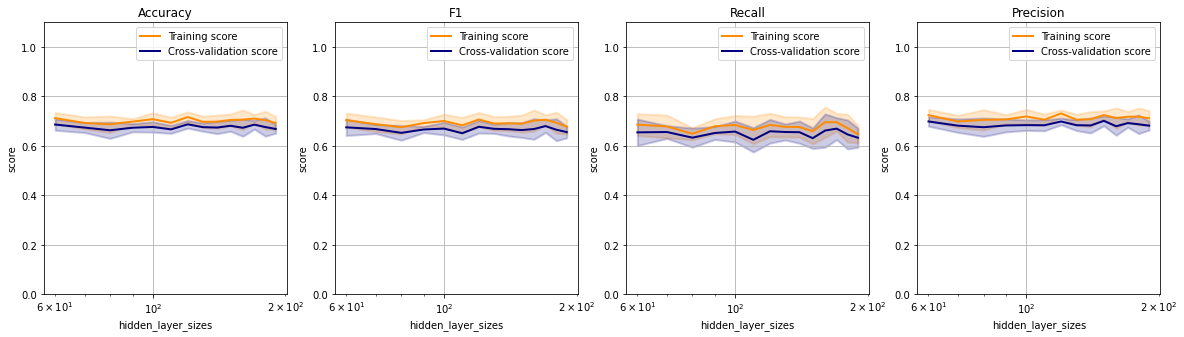

In [12]:
# optimize hidden_layer_sizes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_range = range(60, 200, 10)
scoring = ['accuracy', 'f1', 'recall', 'precision']

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='sgd', alpha=1e-2, random_state=0, max_iter=1000)

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='hidden_layer_sizes', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=5, undersampling_ratio=1, is_pipe=True)



### regularization alpha

In [24]:
# optimize regularization alpha
param_range = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

results = []
scoring = 'precision'
for i in param_range:
    classifier = MLPClassifier(solver='sgd', hidden_layer_sizes=10, random_state=0, max_iter=1000)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    results.append((i, *fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring=scoring)))

print(results)

(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
(5267, 64) (5267,) (586, 64) (586,)
[(1e-05, 0.0243161094224924, 0.013605442176870748, Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=10, max_iter=1000,
                               random_state=0, solver='sgd'))])), (0.0001, 0.0243161094224924, 0.013605442176870748, Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=10, max_iter=1000,
                               random_state=0, solver='sgd'))])), (0.001, 0.0243161094224924, 0.013605442176870748, Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassi

In [5]:
# optimize regularization alpha
param_range = range(1,20)

results = []
for i in param_range:
    classifier = MLPClassifier(solver='sgd', alpha=1e-2, hidden_layer_sizes=i, random_state=0, max_iter=1000)
    shuffle = BalancedUndersamplingShuffle(n_splits=20, test_size=0.2, random_state=i)
    results.append((i, *fit_and_score_pipeline(classifier, X, y, shuffle)))




(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)
(3345, 64) (3345,) (837, 64) (837,)


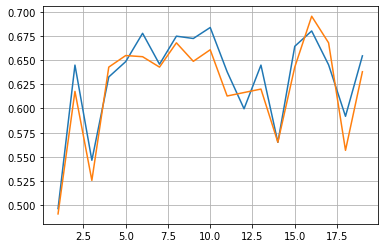

In [16]:
results
plot_data = np.array([(row[0], row[1], row[2]) for row in results])
import matplotlib.pyplot as plt

plt.plot(plot_data[:,0], plot_data[:,1])
plt.plot(plot_data[:,0], plot_data[:,2])
plt.grid()
plt.show()

In [ ]:
# Naive fit
classifier = MLPClassifier()
train, test = list(cv.split(X, y))[0]
scorer = check_scoring(classifier, scoring='accuracy')
estimator_params = dict(solver='sgd', learning_rate='adaptive', alpha=1, hidden_layer_sizes=100, random_state=0)
verbose = 0

results = _fit_and_score(classifier, X, y, scorer, train, test, verbose,
                         parameters=estimator_params, fit_params=None,
                         return_train_score=True, return_n_test_samples=True,
                         return_times=True, return_parameters=True,
                         error_score='raise')
results

In [ ]:
param_range = range(1,20)
classifier = MLPClassifier(random_state=0, solver='lbfgs', alpha=0.01, activation='logistic')
cv = BalancedUndersamplingShuffle(n_splits=50, test_size=0.2, random_state=0)
train_scores, test_scores = plot_validation_curve(classifier, X, y, 
                      param_name='hidden_layer_sizes', param_range=param_range,
                      cv=cv, scoring='accuracy', n_jobs=8)
test_scores_mean = np.mean(test_scores, axis=1)
optimal_max_depth = np.argmax(test_scores_mean)
print(f'optimal_max_depth={optimal_max_depth}, accuracy={test_scores_mean[optimal_max_depth]}')

# Learning Curve

<module 'matplotlib.pyplot' from '/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/matplotlib/pyplot.py'>

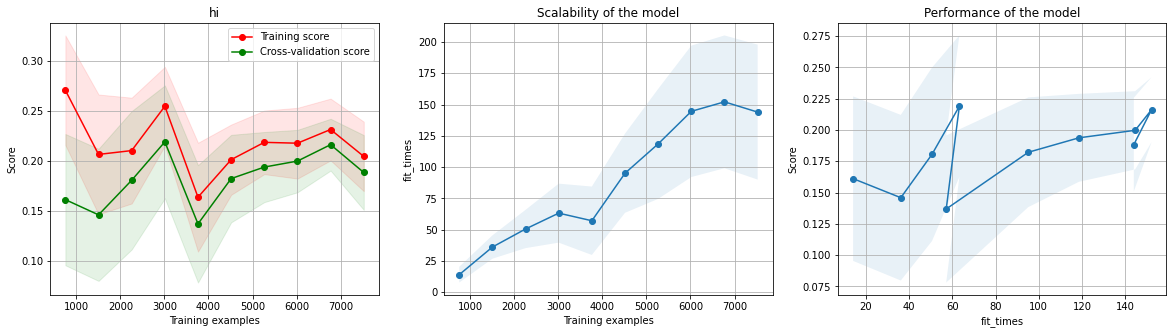

In [50]:
classifier = MLPClassifier(solver='sgd', alpha=1e-2, hidden_layer_sizes=30, random_state=0, max_iter=1000)

pa
title = 'hi'
plot_learning_curve(pipe, title, X, y, axes=None, ylim=None, cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10), scoring='f1')